In [ ]:
import numpy as np

def propagate_water(dem: np.ndarray, start: tuple[int, int], n: float, slope_threshold: float = 1.0, buffer_radius: int = 100):
    dem = dem.copy()
    visited = set()
    current = start
    dem[current] += n  # Add initial height to the lake

    directions = [(-1, -1), (-1, 0), (-1, 1),
                  ( 0, -1),          ( 0, 1),
                  ( 1, -1), ( 1, 0), ( 1, 1)]

    modified = np.zeros_like(dem, dtype=bool)
    modified[current] = True

    while True:
        visited.add(current)
        cx, cy = current
        current_elev = dem[cx, cy]

        max_slope = -np.inf
        next_cell = None

        for dx, dy in directions:
            nx, ny = cx + dx, cy + dy
            if 0 <= nx < dem.shape[0] and 0 <= ny < dem.shape[1]:
                if (nx, ny) in visited:
                    continue
                neighbor_elev = dem[nx, ny]
                slope = current_elev - neighbor_elev
                if slope > max_slope:
                    max_slope = slope
                    next_cell = (nx, ny)

        if max_slope > slope_threshold and next_cell:
            dem[next_cell] += n
            modified[next_cell] = True
            current = next_cell
        else:
            break
    # return modified
    # Create influence map (values between 0 and 1)
    influence = np.zeros_like(dem, dtype=np.float32)
    sigma = buffer_radius / 2.0
    height, width = dem.shape

    for cx, cy in zip(*np.where(modified)):
        base_elev = dem[cx, cy]
        min_x = max(0, cx - buffer_radius)
        max_x = min(height, cx + buffer_radius + 1)
        min_y = max(0, cy - buffer_radius)
        max_y = min(width, cy + buffer_radius + 1)

        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                dist = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
                if dist <= buffer_radius:
                    gauss_weight = np.exp(- (dist ** 2) / (2 * sigma ** 2))
                    elevation_threshold = base_elev + (n * gauss_weight)
                    if dem[x, y] <= elevation_threshold:
                        # maximum flood is taken if several floods overlap
                        influence[x, y] = max(influence[x, y], gauss_weight)

    return influence

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dem(dem: np.ndarray, title: str = "DEM", cmap: str = "terrain", point: tuple[int, int] = None):
    plt.figure(figsize=(10, 8))
    plt.imshow(dem, cmap=cmap)
    plt.colorbar(label="Elevación (m)")
    plt.title(title)
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.grid(False)

    if point is not None:
        y, x = point  # recordar: imshow usa (y, x)
        plt.plot(x, y, color='blue', marker='o', markersize=5, label="Punto inicial")
        plt.legend()

    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_dem_and_modified(dem, modified):
    plt.figure(figsize=(10, 8))
    # Background: DEM in gray
    plt.imshow(dem, cmap='grey')
    # Overlay: modified in blue with transparency
    plt.imshow(modified, cmap='BrBG_r', alpha=0.5)
    plt.colorbar(label='DEM Elevation')
    plt.title('DEM con área modificada resaltada')
    plt.show()

Claves disponibles: ['matrix', 'pixel_resolution', 'bbox']


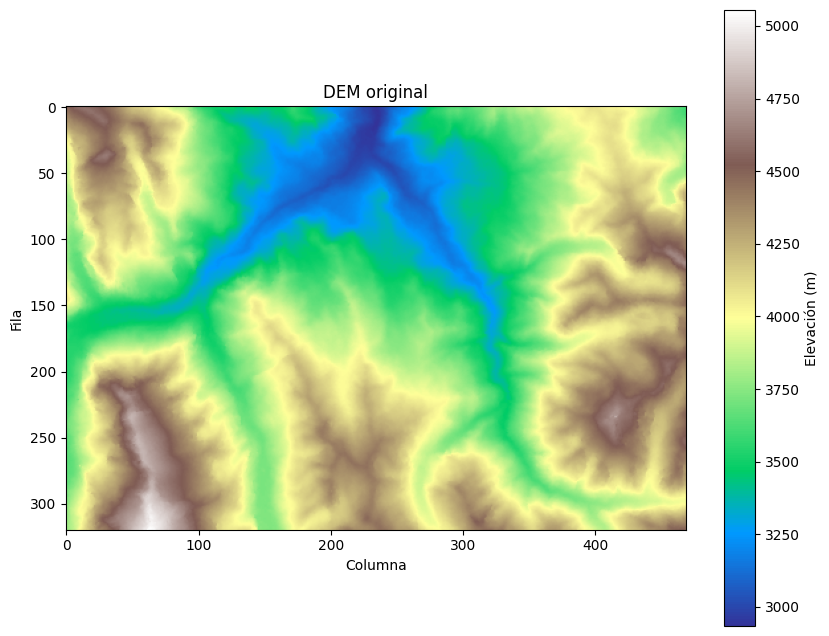

In [ ]:
import numpy as np

# --- Load data from .npz file ---
data = np.load("matrix.npz")
print("Available keys:", data.files)
elevation = data["matrix"]  # the correct key is used"
plot_dem(elevation, "original DEM")

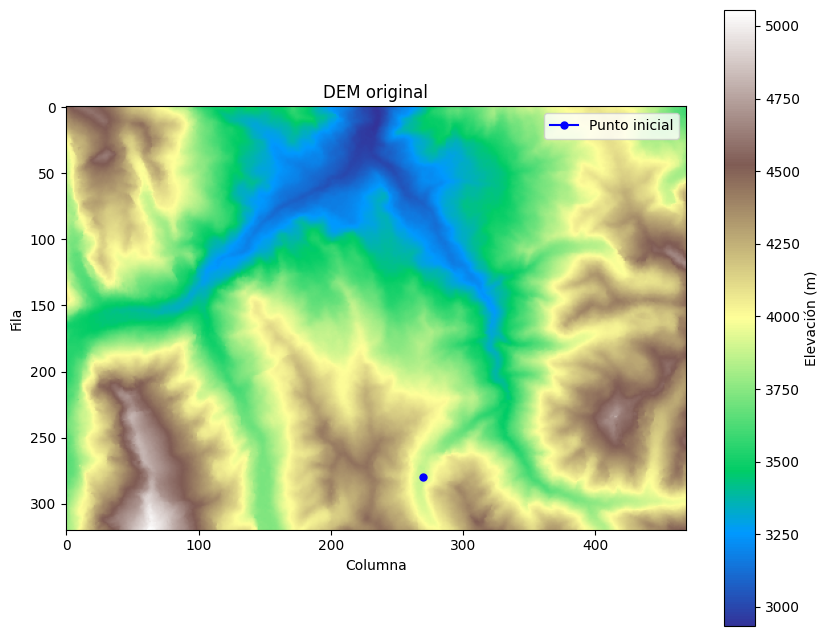

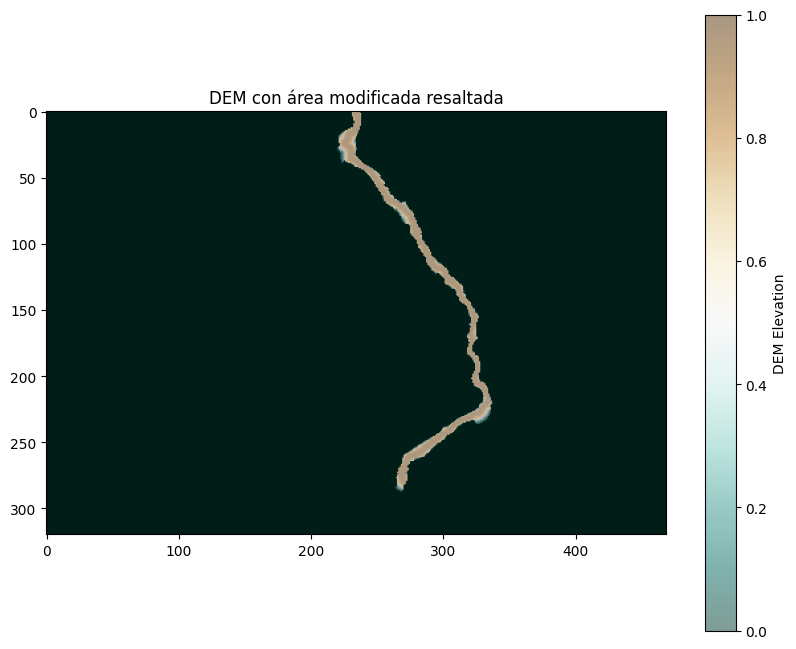

In [ ]:

# lake_pos = (195, 700) # parol
# n = 38
# lake_pos = (260, 450) # piticocha
# n=10
# lake_pos = (300, 420)  # nn1
# n=8
# lake_pos = (160, 380)  # demanda
# n = 10
lake_pos = (280, 270) # patarcocha
n = 11

new_dem = propagate_water(elevation, lake_pos, n, buffer_radius=8)

plot_dem(elevation, "original DEM", point=lake_pos)
plot_dem_and_modified(new_dem, new_dem)


In [ ]:
# prompt: guardar new_dem en npz

import numpy as np
np.savez_compressed("patarcocha.npz", matrix=new_dem)
print("Archivo 'new_dem.npz' guardado correctamente.")

Archivo 'new_dem.npz' guardado correctamente.


/tmp/ipython-input-3223304370.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')


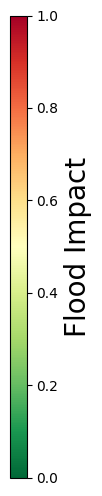

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors


cmap = cm.get_cmap('RdYlGn_r')
norm = colors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(figsize=(0.45, 6))
fig.subplots_adjust(right=0.5)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=ax,
                    orientation='vertical')
cbar.set_label('Flood Impact', fontsize=20)

plt.show()